In [1]:
cd ..

/home/jovyan


In [2]:
%run __init__.py
%run src/load_data.py
sns.set()

In [3]:
adult_train_engineered_df = data['adult']['train']['engineered']
adult_train_scaled_df = data['adult']['train']['scaled']
adult_train_gelman_scaled_df = data['adult']['train']['gelman_scaled']
madelon_train_raw_data_df = data['madelon']['train']['raw_data']
madelon_train_scaled_df = data['madelon']['train']['scaled']

In [4]:
del MinMaxScaler                   
del StandardScaler                 
del adult_feature_engineering      
del adult_test_data                
del adult_test_labels              
del adult_train_data               
del data                           
del get_ipython                    
del madelon_test_data              
del madelon_test_labels            
del madelon_train_data             
del scale                          
del scaler                         

- Can you describe how the data look in the new spaces you created with the various aglorithms? For PCA, what is the distribution of eigenvalues? For ICA, how kurtotic are the distributions? Do the projection axes for ICA seem to capture anything "meaningful"? Assuming you only generate k projections (i.e., you do dimensionality reduction), how well is the data reconstructed by the randomized projections? PCA? How much variation did you get when you re-ran your RP several times (I know I don't have to mention that you might want to run RP many times to see what happens, but I hope you forgive me)?

In [38]:
pca_madelon_recon_err = pd.read_pickle('data/madelon-pca-recon-err.p')
pca_adult_recon_err = pd.read_pickle('data/adult-pca-recon-err.p')

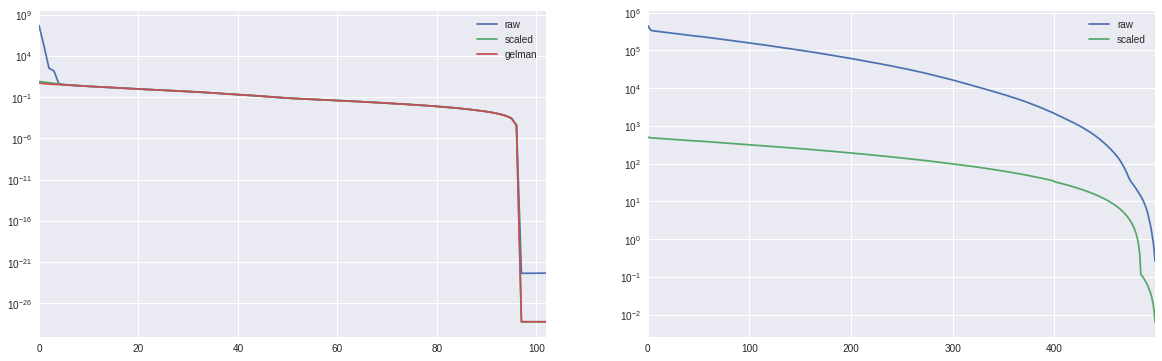

In [6]:
_, ax = plt.subplots(1,2, figsize=(20,6))
pca_adult_recon_err.plot(ax=ax[0], logy=True)
pca_madelon_recon_err.plot(ax=ax[1], logy=True)

In [7]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
display(adult_train_gelman_scaled_df.shape[0], johnson_lindenstrauss_min_dim(adult_train_gelman_scaled_df.shape[0],eps=0.1))
display(madelon_train_scaled_df.shape[0], johnson_lindenstrauss_min_dim(madelon_train_scaled_df.shape[0],eps=0.1))

25071

8682

2000

6515

> Random projections are made possible by the Johnson-Lindenstrauss lemma which states that there exists a mapping from a high-dimensional to a low-dimensional Euclidean space, such that the distance between the points is preserved, within some epsilon variance.

http://blog.yhat.com/posts/sparse-random-projections.html

Given that we have 25071 data points, in order to preserve their pairwise Euclidean distances within a tolerance of 0.1 epsilon, our random projection matrix should have 8682 components.

Given that we have 2000 data points, in order to preserve their pairwise Euclidean distances within a tolerance of 0.1 epsilon, our random projection matrix should have 6515 components.

In [6]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import datasets

RangeIndex(start=0, stop=103, step=1)

In [10]:
accuracies_adult = []
components_adult = list(pca_adult_recon_err.index)
recon_err_adult = []
accuracies_madelon = []
components_madelon = list(pca_madelon_recon_err.index)
recon_err_madelon = []

In [11]:
adult_split = train_test_split(adult_train_gelman_scaled_df, adult_train_labels, test_size = 0.3, random_state = 42)
madelon_split = train_test_split(madelon_train_scaled_df, madelon_train_labels, test_size = 0.3, random_state = 42)

In [12]:
model_ad = AdaBoostClassifier()
model_ad.fit(adult_split[0], adult_split[2])
baseline_ad = metrics.f1_score(model_ad.predict(adult_split[1]), adult_split[3])

model_mad = DecisionTreeClassifier()
model_mad.fit(madelon_split[0], madelon_split[2])
baseline_mad = metrics.f1_score(model_mad.predict(madelon_split[1]), madelon_split[3])

In [13]:
# !pip install tqdm

In [14]:
from tqdm import tqdm

In [15]:
import scipy.sparse as sps
from scipy.linalg import pinv

In [16]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [18]:
for comp in tqdm(components_adult[1:]):
    # create the random projection
    sp = SparseRandomProjection(n_components = comp)
    X = sp.fit_transform(adult_split[0])
 
    # train a classifier on the sparse random projection
    model_ad = AdaBoostClassifier()
    model_ad.fit(X, adult_split[2])
 
    # evaluate the model and update the list of accuracies
    test = sp.transform(adult_split[1])
    accuracies_adult.append(metrics.f1_score(model_ad.predict(test), adult_split[3]))
    recon_err_adult.append(reconstructionError(sp, adult_split[0]))

  0%|          | 0/102 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


In [45]:
sp = SparseRandomProjection(n_components = 40)
X = pd.DataFrame(sp.fit_transform(adult_train_gelman_scaled_df), columns = ['RP '+str(i) for i in range(1,41)])
X.to_pickle('data/adult_gelman_rp_df.p')

In [19]:
for comp in tqdm(components_madelon[1:]):
    # create the random projection
    sp = SparseRandomProjection(n_components = comp)
    X = sp.fit_transform(madelon_split[0])
 
    # train a classifier on the sparse random projection
    model_mad = DecisionTreeClassifier()
    model_mad.fit(X, madelon_split[2])
 
    # evaluate the model and update the list of accuracies
    test = sp.transform(madelon_split[1])
    accuracies_madelon.append(metrics.f1_score(model_mad.predict(test), madelon_split[3]))
    recon_err_madelon.append(reconstructionError(sp, madelon_split[0]))

100%|██████████| 499/499 [03:53<00:00,  2.14it/s]


In [7]:
sp = SparseRandomProjection(n_components = 100)
X = pd.DataFrame(sp.fit_transform(madelon_train_scaled_df), columns = ['RP '+str(i) for i in range(1,101)])
X.to_pickle('data/madelon_scaled_rd_df.p')

In [20]:
len(components_adult), len(accuracies_adult)

(103, 102)

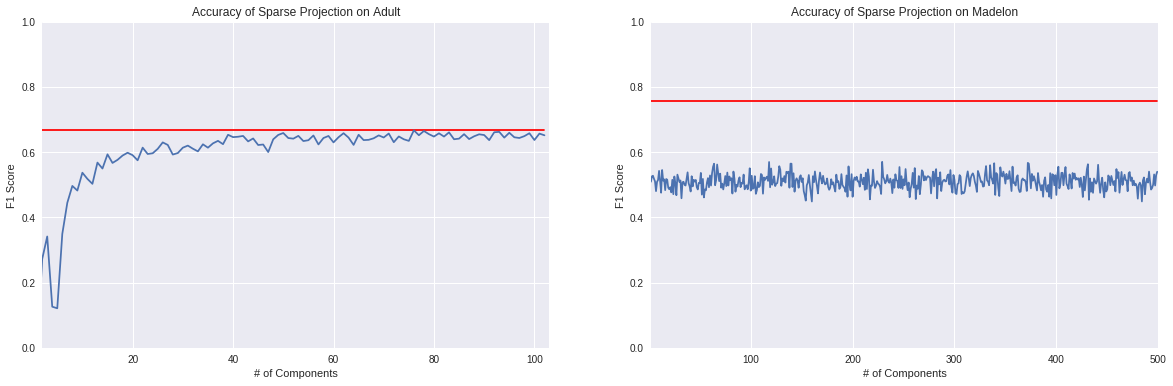

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].set_title("Accuracy of Sparse Projection on Adult")
ax[0].set_xlabel("# of Components")
ax[0].set_ylabel("F1 Score")
ax[0].set_xlim([2, 103])
ax[0].set_ylim([0, 1.0])
ax[0].plot(components_adult[1:], [baseline_ad] * len(accuracies_adult), color = "r")
ax[0].plot(components_adult[1:], accuracies_adult)

ax[1].set_title("Accuracy of Sparse Projection on Madelon")
ax[1].set_xlabel("# of Components")
ax[1].set_ylabel("F1 Score")
ax[1].set_xlim([2, 500])
ax[1].set_ylim([0, 1.0])
ax[1].plot(components_madelon[1:], [baseline_mad] * len(accuracies_madelon), color = "r")
ax[1].plot(components_madelon[1:], accuracies_madelon)

In [ ]:
sp = SparseRandomProjection(n_components = comp)
reconstructionError(srp_madelon, madelon_train_f)

In [ ]:
pca_adult_recon_err['rp'].dropna()

In [39]:
pca_adult_recon_err['rp'] = pd.Series(recon_err_adult, index=components_adult[1:])
pca_madelon_recon_err['rp'] = pd.Series(recon_err_madelon, index=components_madelon[1:])

In [40]:
pca_adult_recon_err.dropna(inplace=True)
pca_madelon_recon_err.dropna(inplace=True)

In [41]:
pca_adult_recon_err.columns = ['pca raw', 'pca scaled', 'pca gelman', 'rp']
pca_madelon_recon_err.columns = ['pca raw', 'pca scaled', 'rp']

Text(0.5,0,'n components')

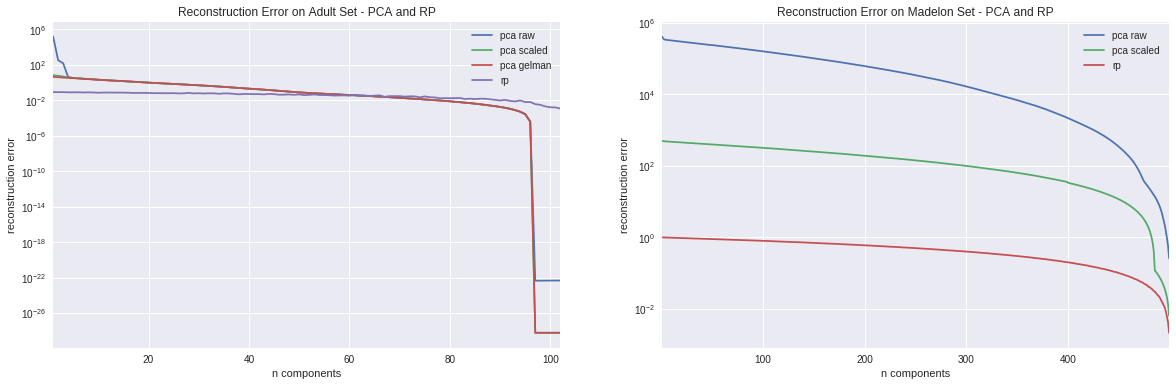

In [42]:
_, ax = plt.subplots(1,2, figsize=(20,6))
pca_adult_recon_err.plot(ax=ax[0], logy=True)
pca_madelon_recon_err.plot(ax=ax[1], logy=True)
ax[0].set_ylabel('reconstruction error')
ax[0].set_xlabel('n components')
ax[0].set_title('Reconstruction Error on Adult Set - PCA and RP')
ax[1].set_title('Reconstruction Error on Madelon Set - PCA and RP')
ax[1].set_ylabel('reconstruction error')
ax[1].set_xlabel('n components')

In [24]:
reconstructionError(srp_madelon, madelon_train_f)

0.79983706485945982